## Fraud Detection System (사기거래 탐지)
1. Autoencoder를 이용한 이상거래 탐지
    1. 데이터 로드 (캐글 데이터)
    2. 데이터 전처리 (smote, z-score)
    3. Autoencoder
    4. +DNN/ANN (이거 해야하는지 찾아보기)

2. Isolation Forest

In [1]:
# 수학적 모듈
import numpy as np
import pandas as pd

# 데이터 확인을 위한 모듈
import missingno as msno

# 시각화를 위한 모듈
import seaborn as sns
import matplotlib.pyplot as plt

# 딥러닝/머신러닝을 위한 모듈
from imblearn.over_sampling import SMOTE
    # [불균형 데이터 oversampling]
from sklearn.model_selection import train_test_split
    # [train, test set 분리]
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
    # [Keras ModelCheckpoint 메커니즘이 평균 제곱 오차 및 정확도 지표를 기반으로 최적의 Autoencoder 모델을 자동으로 저장]
from keras import regularizers

# 데이터 훈련 후 거래의 유효성을 예측하기 위한 분류 모델을 구현하기 위해 우리는 "tensorflow.keras.models"에서 "Sequential" 모듈을 가져왔습니다.

# from sklearn import IsolationForest

# 평가를 위한 모듈
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import copy

### 1. Autoencoder를 이용한 사기거래탐지

##### 1) 데이터 로드 및 데이터 확인

- 데이터 출처
    - Kaggle, Credit Card Fraud Detection
- 데이터 설명
    - The dataset contains transactions made by credit cards in September 2013 by European cardholders.
    - It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data.(보안 상의 이유로 실제 변수를 공개할 수 없기 때문에 사전에 PCA를 통해 변환된 변수를 포함한 데이터셋을 제공한다.)

In [2]:
# 데이터 로드
credit_data = pd.read_csv("/content/drive/MyDrive/2023_우리FIS_ITStudy/1차 기술세미나/creditcard.csv")

In [3]:
# 복사
credit_data_copy = copy.deepcopy(credit_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

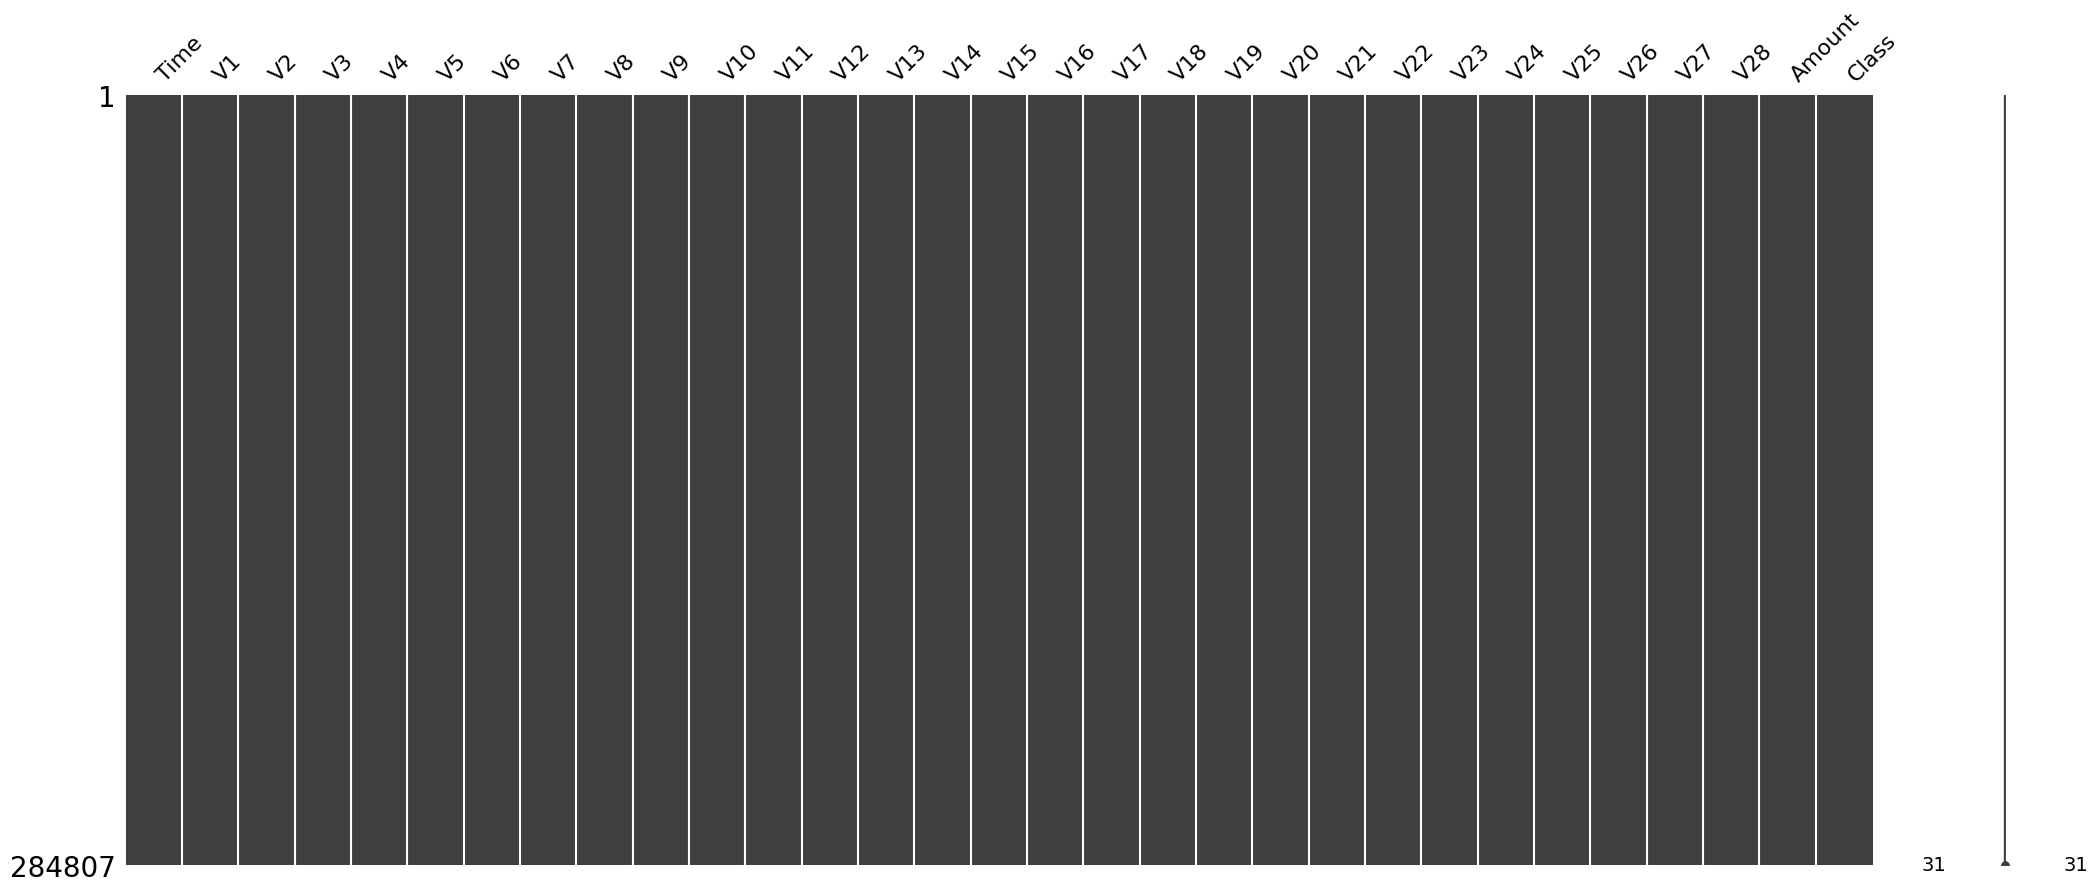

In [ ]:
# 데이터 확인

# 결측치 확인
msno.matrix(credit_data)
credit_data.isna().sum()
    # [결측치 없음]

# 데이터 자료형 확인
credit_data.info()
    # [전 변수 수치형]

In [ ]:
credit_data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
# Fraud 변수 확인

pd.value_counts(credit_data['Class'], sort = True)
    # [Fraud : 492, Normal : 284315]

0    284315
1       492
Name: Class, dtype: int64

##### 2) 데이터 전처리
- Smote
    - 지도학습을 진행할 때는 데이터의 불균형 때문에 학습이 제대로 되지 않기 때문에 smote를 이용하여 정상 거래와 비정상 거래 간 균형을 맞춰준다.
    - 현재는 비지도 학습의 일환인 autoencoder를 이용하기 때문에 smote 과정을 생략한다.
- Z-scale 정규화(표준정규)
    - 이미 PCA 후의 변수들만 가지고 분석 중이기 때문에 Amount 변수에 대해서만 정규화를 진행한다.

In [ ]:
# credit_data = credit_data_copy

##### smote

In [ ]:
# (1) Smote

def smote_oversampling(df: pd.DataFrame):
    X = df.iloc[:, 1:-2]
    y = df["Class"]

    smote = SMOTE(random_state = 2023, sampling_strategy = 'minority')
    X_smote, y_smote = smote.fit_resample(X, y)

    return X_smote, y_smote

In [ ]:
X_smote, y_smote = smote_oversampling(credit_data)
X_smote, y_smote

(               V1         V2         V3        V4         V5        V6  \
 0       -1.359807  -0.072781   2.536347  1.378155  -0.338321  0.462388   
 1        1.191857   0.266151   0.166480  0.448154   0.060018 -0.082361   
 2       -1.358354  -1.340163   1.773209  0.379780  -0.503198  1.800499   
 3       -0.966272  -0.185226   1.792993 -0.863291  -0.010309  1.247203   
 4       -1.158233   0.877737   1.548718  0.403034  -0.407193  0.095921   
 ...           ...        ...        ...       ...        ...       ...   
 568625   0.246536   3.994243  -5.909896  6.301303   1.367408 -3.001708   
 568626  -0.404681  -0.296837  -1.295866 -0.067140   1.566793 -1.408600   
 568627  -6.954499   3.541389  -9.578084  5.241556  -4.294215 -2.682369   
 568628  -3.719420   1.415591  -2.674505  4.162597  -3.240417  0.765044   
 568629 -26.457745  16.497472 -30.177317  8.904157 -17.892600 -1.227904   
 
                V7         V8        V9        V10  ...       V19       V20  \
 0        0.239599 

In [ ]:
y_smote.value_counts()
    # [소수 클래스 증폭]

0    284315
1    284315
Name: Class, dtype: int64

In [ ]:
# X_smote, y_smote 합치기 : Autoencoder는 'Class' == 0(정상)인 데이터로만 학습시켜야 하기 때문
credit_data_smote = pd.concat([X_smote, y_smote], axis = 1)
credit_data_smote

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,0.246536,3.994243,-5.909896,6.301303,1.367408,-3.001708,-0.961785,-0.024434,-2.625170,-5.521688,...,0.457515,0.226343,-0.604136,-0.587296,-0.213597,1.539962,0.516925,0.601986,0.448123,1
568626,-0.404681,-0.296837,-1.295866,-0.067140,1.566793,-1.408600,0.225838,-0.774726,0.429207,-0.111592,...,-0.788790,1.012516,1.533966,0.096700,0.637390,-0.524898,-0.280326,0.253079,0.022040,1
568627,-6.954499,3.541389,-9.578084,5.241556,-4.294215,-2.682369,-6.737672,3.740652,-4.637615,-8.440307,...,0.447621,1.067724,-0.520141,0.058538,-0.351675,0.363313,1.050313,1.428983,-0.301545,1
568628,-3.719420,1.415591,-2.674505,4.162597,-3.240417,0.765044,-2.896220,0.408047,-2.549289,-3.970750,...,-0.506009,1.282815,0.991742,0.668843,-0.183367,-0.149090,0.109715,0.773842,-0.438059,1


##### 3-1) 모델링 with Class
- Autoencoder 모델에는 '정상'데이터만 학습되어야 하기 때문에 X_train은 ['Class'] == 0인 데이터들만 포함되어야 함
- X_test에는 모든 데이터가 포함됨
- 8:2의 비율로 (X) train:test 설정

In [ ]:
# Train set 나누기 - smote O
'''
X_train, X_test = train_test_split(credit_data_smote, test_size = 0.2, random_state = 2023)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)
X_test = X_test.drop(['Class'], axis = 1)

y_test = credit_data_smote['Class']

X_train = X_train.values
X_test = X_test.values

X_train.shape
'''

(227431, 28)

In [4]:
# Train set 나누기 - smote X

X = credit_data.drop(['Time', 'Amount'], axis = 1)
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 2023)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis = 1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis = 1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227443, 28)

 Autoencoder 모델 생성

In [40]:
# AutoencoderClass() : Autoencoder 모델 정의, 모델 훈련, 이상치 탐지 과정을 담은 클래스 생성

class AutoencoderClass():

    # (1) autoencoder 모델 정의
    def model_define(self, input_dim: int, encoding_dim: int):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim

        # 입력층
        input_layer = Input(shape = (input_dim,))
            # [shape: 입력 데이터의 형태를 알려주어서 이 형태에 맞게 가중치를 초기화하고 모델을 구성할 수 있도록 함,
            # [       입력데이터의 차원 수를 입력함으로써 입력할 X_train의 shape를 미리 적용시킨 것]

        # encoder : 2개의 layer
        encoder = Dense(encoding_dim, activation = "tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
            # [활성화 함수 = 'tanh' : 출력을 -1과 1사이의 값으로 정규화, 주로 데이터를 정규화하고 가우시안 분포에 가깝게 만들기 위해 사용]
            # [regularizer = 'L1' : 가중치 축소를 통해 모델의 복잡성을 줄여 과적합을 방지함,
            # [                     희소한 모델을 유도하기 때문에 모델이 덜 중요한 특성은 무시할 수 있음, 더 중요한 특성을 반영할 수 있게 되어 간결한 표현을 얻을 수 있기 때문에 이상치 탐지에서 효과적]
        encoder = Dense(int(encoding_dim/2), activation = 'relu')(encoder)
            # [앞의 첫 encoder layer의 출력을 받아 '앞의 뉴런 수'/2 만큼의 뉴런 수로 fully connected layer로 변환함]
            # ['encoding_dim/2' 만큼으로 차원 축소]
            # [활성화 함수 = 'relu' : 입력이 양수인 경우에는 입력 값을 그대로 출력하고, 음수인 경우에는 0을 출력, 주로 비선형성을 추가하여 모델이 더 복잡한 패턴을 학습할 수 있게 도와줌]

        # decoder_2개의 layer
        decoder = Dense(int(encoding_dim / 2), activation = 'tanh')(encoder)
            # [두 번째 인코더 레이어의 출력을 받아 똑같이 encoding_dim/2개의 뉴런을 가지는 fully connected layer로 변환]
        decoder = Dense(input_dim, activation = 'relu')(decoder)
            # [원래 차원인 input_dim개의 뉴런을 가지는 fully connected layer로 변환]

        # Autoencoder Model 생성
        autoencoder = Model(inputs = input_layer, outputs = decoder)
            # [Model() : keras에서 모델을 생성하는 클래스. 입력 레이어에서 출력 레이어까지의 전체 모델 정의 가능]
        self.autoencoder = autoencoder


    # (2) 모델 훈련
    def model_train(self, epoch: int, batch_size: int, train_input: pd.DataFrame, train_output: pd.DataFrame):
        self.epoch = epoch
        self.batch_size = batch_size
        self.train_input = train_input
        self.train_output = train_output

        self.autoencoder.compile(optimizer = 'adam',
                                loss = 'mean_squared_error',
                                metrics=['mse'])
            # [compile : Keras 모델을 훈련 가능한 상태로 만들어주는 메서드]
            # [optimizer = 'adam' : 최적화 알고리즘, ]
            # [recall : FN(이상 데이터인데 정상 데이터라고 잘못 판별한 경우)을 감소시키는 평가지표]

        checkpointer = ModelCheckpoint(filepath = "model.h5",
                                    verbose=0,
                                    save_best_only = True)
            # [모델 파일 ; 확장자 .h5, hdf5]

        tensorboard = TensorBoard(log_dir='./logs',
                                histogram_freq=0,
                                write_graph=True,
                                write_images=True)

        history = self.autoencoder.fit(self.train_input, self.train_output,
                                epochs = self.epoch,
                                batch_size = self.batch_size,
                                shuffle=True,
                                validation_data=(X_test, X_test),
                                verbose=1,
                                callbacks=[checkpointer, tensorboard]).history

    # (3) 이상치 탐지
    def outlier_detection(self, X_test: pd.DataFrame):
        self.X_test = X_test
        reconstructions = self.autoencoder.predict(self.X_test)
        mse = np.mean(np.power(self.X_test - reconstructions, 2), axis = 1)

        error_df = pd.DataFrame({'reconstruction_error' :mse,
                                'true_class': y_test})

        # 정상 vs 이상 데이터 간 재구성오차 히스토그램
        # 정상 데이터
        fig = plt.figure()
        ax = fig.add_subplot(111)
        normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
        _ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
        plt.ylabel("count")
        plt.xlabel("range of reconstruction errors")

        # 이상 데이터
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fraud_error_df = error_df[error_df['true_class'] == 1]
        _ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
        plt.ylabel("count")
        plt.xlabel("range of reconstruction errors")
            # [사기거래일수록 재구성오류(reconstruction_error)의 크기가 큰 경우가 다수 포진해 있음을 확인할 수 있다.]
            # [깨끗한 트랜잭션의 대부분은 2 미만의 재구성 손실을 갖는 반면 사기 트랜잭션의 경우 재구성 손실은 10까지 높을 수 있음을 알 수 있습니다.]
            # [이는 오토인코더가 사기 트랜잭션보다 깨끗한 트랜잭션을 더 정확하게 재구성할 수 있음을 의미합니다.]
        plt.show();

        # Precision, Recall 그래프
        precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

        plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
        plt.title('Precision for different threshold values')
        plt.xlabel('Threshold')
        plt.ylabel('Precision')
        plt.xlim([0,200])
        # plt.show()

        plt.plot(th, recall[1:], 'r', label='Threshold-Recall curve')
        plt.title('Recall for different threshold values')
        plt.xlabel('Threshold')
        plt.ylabel('Recall')
        plt.xlim([0,200])
        plt.show();

        self.error_df = error_df
        return reconstructions, error_df

    # (4) 결과 시각화
    def visualization(self, threshold: int):
        self.threshold = threshold
        groups = self.error_df.groupby('true_class')
        fig, ax = plt.subplots()

        for name, group in groups:
            ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                    label= "Fraud" if name == 1 else "Normal")
        ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
        ax.legend()
        plt.title("Reconstruction error for different classes")
        plt.ylabel("Reconstruction error")
        plt.xlabel("Data point index")
        plt.ylim([0, 600])
        plt.show();

    # (5) 평가
    def autoencoder_evaluation(self):
        LABELS = ["Normal", "Fraud"]
        y_pred = [1 if e > self.threshold else 0 for e in self.error_df.reconstruction_error.values]
            # [재구성오차가 threshold 이상인 데이터를 사기거래로 예측]
        conf_matrix = confusion_matrix(self.error_df.true_class, y_pred)
        plt.figure(figsize=(6,6))
        sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
        plt.title("Confusion matrix")
        plt.ylabel('True class')
        plt.xlabel('Predicted class')
        plt.show()

In [41]:
# 모델 정의
Autoencoder = AutoencoderClass()
Autoencoder.model_define(input_dim = X_train.shape[1], encoding_dim = 14)

In [42]:
# 모델 훈련
Autoencoder.model_train(epoch = 10, batch_size = 258, train_input = X_train, train_output = X_train)

Epoch 1/10
882/882 [==============================] - 5s 4ms/step - loss: 0.8991 - mse: 0.8984 - val_loss: 0.9035 - val_mse: 0.9028
Epoch 2/10
 34/882 [>.............................] - ETA: 2s - loss: 0.7898 - mse: 0.7891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


882/882 [==============================] - 3s 4ms/step - loss: 0.7914 - mse: 0.7907 - val_loss: 0.8568 - val_mse: 0.8561
Epoch 3/10
882/882 [==============================] - 3s 3ms/step - loss: 0.7641 - mse: 0.7635 - val_loss: 0.8408 - val_mse: 0.8402
Epoch 4/10
882/882 [==============================] - 2s 2ms/step - loss: 0.7516 - mse: 0.7510 - val_loss: 0.8313 - val_mse: 0.8308
Epoch 5/10
882/882 [==============================] - 2s 2ms/step - loss: 0.7432 - mse: 0.7426 - val_loss: 0.8242 - val_mse: 0.8236
Epoch 6/10
882/882 [==============================] - 2s 2ms/step - loss: 0.7370 - mse: 0.7364 - val_loss: 0.8179 - val_mse: 0.8173
Epoch 7/10
882/882 [==============================] - 2s 2ms/step - loss: 0.7324 - mse: 0.7318 - val_loss: 0.8139 - val_mse: 0.8134
Epoch 8/10
882/882 [==============================] - 3s 4ms/step - loss: 0.7287 - mse: 0.7282 - val_loss: 0.8110 - val_mse: 0.8104
Epoch 9/10
882/882 [==============================] - 3s 3ms/step - loss: 0.7264 - mse:

1781/1781 [==============================] - 2s 1ms/step


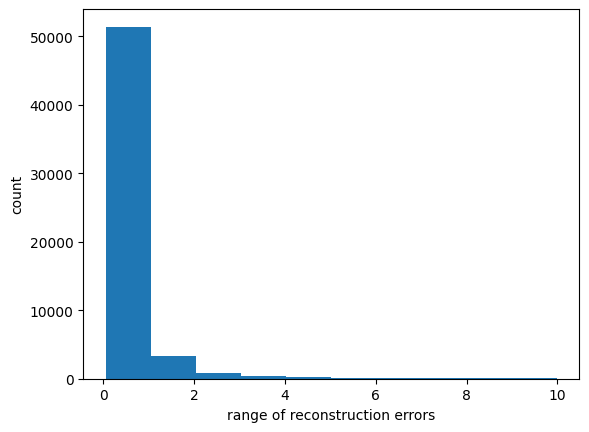

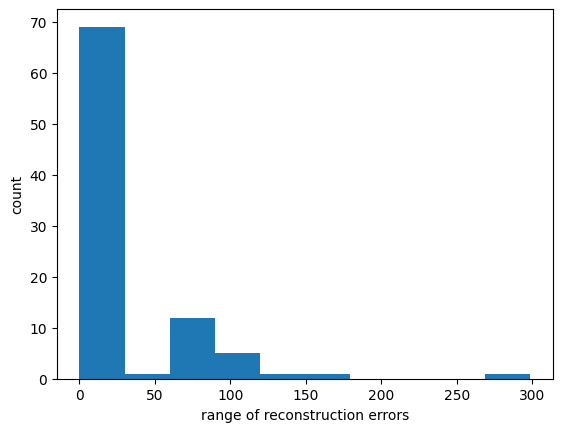

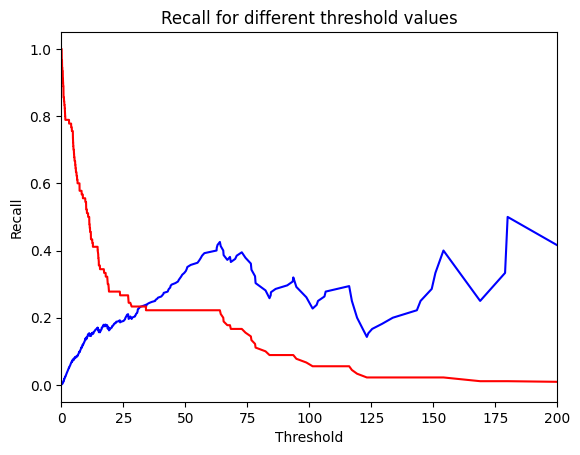

In [43]:
# 이상치 탐지
reconstruction, error_df = Autoencoder.outlier_detection(X_test = X_test)


높은 정밀도(FP)는 거짓(정상 데이터)인데 참(사기 데이터)이라고 예측한 것들의 비율이 낮은 것과 관련 있고, 높은 재현율(FN)은 참(사기 데이터)인데 거짓(정상 데이터)이라고 예측한 것들의 비율이 낮은 것과 관련 있다.

두 값 모두 높다면 해당 분류기가 실제 참인 데이터들 중 대부분을 찾아낼(높은 재현율)뿐만 아니라, 정확한 결과(높은 정밀도)를 가진다는 것을 의미한다.

하지만 FN의 경우가 손실이 더 크기 때문에 FN을 감소시키는 전략을 취하는 것이 적합할 것이다. 따라서 재현율에 더 초점을 맞추어 평가한다.

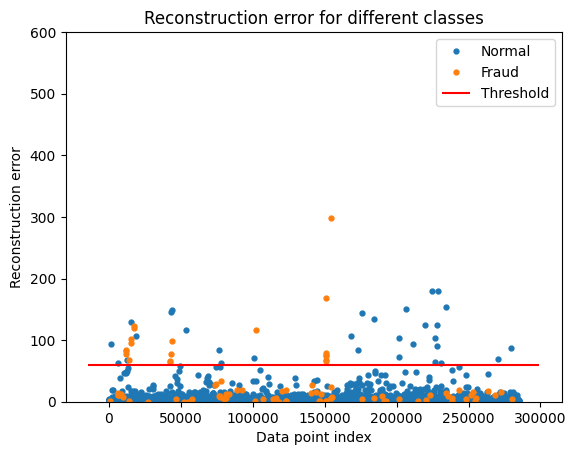

In [44]:
# 이상치 시각화
Autoencoder.visualization(threshold = 60)

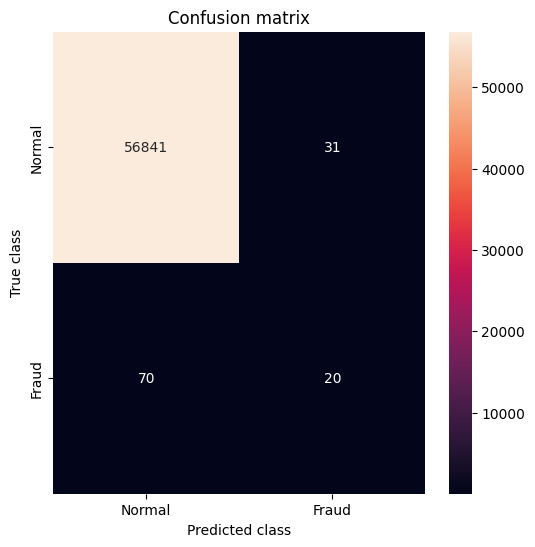

In [45]:
# 평가
Autoencoder.autoencoder_evaluation()



---



##### 3-2) 모델링 not Class

In [ ]:
# (1) 함수형 API를 사용하여 직접 레이어 연결
input_dim = X_train.shape[1]
    # [입력데이터의 차원 수]
encoding_dim = 14
    # [뉴런의 수]

# 입력층
input_layer = Input(shape = (input_dim,))
    # [shape: 입력 데이터의 형태를 알려주어서 이 형태에 맞게 가중치를 초기화하고 모델을 구성할 수 있도록 함.]
    # [shape : 입력데이터의 차원 수를 입력함으로써 입력할 X_train의 shape를 미리 적용시킨 것]

# encoder_2개의 layer
encoder = Dense(encoding_dim, activation = "tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
    # [활성화 함수 = 'tanh' : 출력을 -1과 1사이의 값으로 정규화, 주로 데이터를 정규화하고 가우시안 분포에 가깝게 만들기 위해 사용]
    # [regularizer = 'L1' : 가중치 축소를 통해 모델의 복잡성을 줄여 과적합을 방지함]
    # [+ 희소한 모델을 유도하기 때문에 모델이 덜 중요한 특성은 무시할 수 있음, 더 중요한 특성을 반영할 수 있게 되어 간결한 표현을 얻을 수 있기 때문에 이상치 탐지에서 효과적]
encoder = Dense(int(encoding_dim / 2), activation = 'relu')(encoder)
    # [앞의 첫 encoder layer의 출력을 받아 '앞의 뉴런 수'/2 만큼의 뉴런 수로 fully connected layer로 변환함]
    # ['encoding_dim/2' 만큼으로 차원 축소]
    # [활성화 함수 = 'relu' : 입력이 양수인 경우에는 입력 값을 그대로 출력하고, 음수인 경우에는 0을 출력, 주로 비선형성을 추가하여 모델이 더 복잡한 패턴을 학습할 수 있게 도와줌]

# decoder_2개의 layer
decoder = Dense(int(encoding_dim / 2), activation = 'tanh')(encoder)
    # [두 번째 인코더 레이어의 출력을 받아 똑같이 encoding_dim/2개의 뉴런을 가지는 fully connected layer로 변환]
decoder = Dense(input_dim, activation = 'relu')(decoder)
    # [원래 차원인 input_dim개의 뉴런을 가지는 fully connected layer로 변환]

# Autoencoder Model 생성
autoencoder = Model(inputs = input_layer, outputs = decoder)
    # [Model() : keras에서 모델을 생성하는 클래스. 입력 레이어에서 출력 레이어까지의 전체 모델 정의 가능]

In [ ]:
# (2) Sequential API를 사용하여 레이어를 쌓아가는 모델
class FraudDetector(Model):
    def __init__(self):
        super(FraudDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(14, activation = 'tanh', activity_regularizer=regularizers.l1(10e-5)),
            layers.Dense(7, activation = 'relu')])

        self.decoder = tf.keras.Sequential([
            layers.Dense(7, activation = 'tanh'),
            layers.Dense(28, activation = 'relu')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = FraudDetector()

모델 훈련

In [ ]:
# 가장 우수한 성능을 가진 모델 저장하기 : ModelCheckpoint
# 에폭 100, 배치사이즈 36 - 전체 훈련 데이터셋이 100번 모델에 전달되는 동안 각각의 전달마다 32개의 데이터 샘플이 사용됨

nb_epoch = 30
    # [100 -> 20 시간관계상]
    # [epoch : 전체 훈련 데이터셋이 모델에 한 번 전달되는 횟수]
    # [에폭이 증가할수록 모델은 훈련 데이터를 많이 '보게'되며 학습이 도움이 되지만, 너무 큰 값으로 설정하면 과적합의 가능성이 있음]
batch_sizes = 36
    # [batch_size : 한 번의 모델 업데이트에 사용되는 데이터 샘플의 개수]
    # [모든 훈련데이터를 한 번에 사용하는 것이 아니라 작은 배치 단위로 나누어 학습함]
    # [작은 배치 사용하면 메모리 효율적 & 모델 업데이트 빠르게 수행, 안정적인 학습, 노이즈에 대한 로버스트한 모델 만들 수 있음]

autoencoder.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics=['mse'])
    # [compile : Keras 모델을 훈련 가능한 상태로 만들어주는 메서드]
    # [optimizer = 'adam' : 최적화 알고리즘, ]
    # [recall : FN(이상 데이터인데 정상 데이터라고 잘못 판별한 경우)을 감소시키는 평가지표]

checkpointer = ModelCheckpoint(filepath = "model.h5",
                               verbose=0,
                               save_best_only = True)
    # [모델 파일 ; 확장자 .h5, hdf5]

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                          epochs = nb_epoch,
                          batch_size = batch_sizes,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Epoch 1/30
6318/6318 [==============================] - 25s 4ms/step - loss: 0.8080 - mse: 0.8074 - val_loss: 0.8396 - val_mse: 0.8390
Epoch 2/30
  68/6318 [..............................] - ETA: 14s - loss: 0.7985 - mse: 0.7979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6318/6318 [==============================] - 16s 3ms/step - loss: 0.7450 - mse: 0.7444 - val_loss: 0.8238 - val_mse: 0.8233
Epoch 3/30
6318/6318 [==============================] - 16s 3ms/step - loss: 0.7351 - mse: 0.7345 - val_loss: 0.8160 - val_mse: 0.8154
Epoch 4/30
6318/6318 [==============================] - 17s 3ms/step - loss: 0.7278 - mse: 0.7271 - val_loss: 0.8074 - val_mse: 0.8067
Epoch 5/30
6318/6318 [==============================] - 16s 3ms/step - loss: 0.7221 - mse: 0.7214 - val_loss: 0.8071 - val_mse: 0.8064
Epoch 6/30
6318/6318 [==============================] - 19s 3ms/step - loss: 0.7195 - mse: 0.7188 - val_loss: 0.8018 - val_mse: 0.8011
Epoch 7/30
6318/6318 [==============================] - 18s 3ms/step - loss: 0.7172 - mse: 0.7165 - val_loss: 0.8008 - val_mse: 0.8001
Epoch 8/30
6318/6318 [==============================] - 21s 3ms/step - loss: 0.7154 - mse: 0.7147 - val_loss: 0.7975 - val_mse: 0.7967
Epoch 9/30
6318/6318 [==============================] - 16s 3ms/st

In [ ]:
autoencoder = load_model('model.h5')

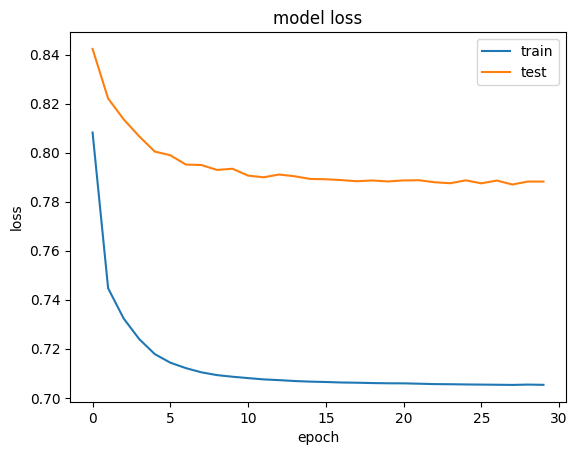

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
# X_test(새로운 데이터) 재구성 오차 계산
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis = 1)

error_df = pd.DataFrame({'reconstruction_error' :mse,
                         'true_class': y_test})
error_df

1781/1781 [==============================] - 2s 1ms/step


,reconstruction_error,true_class
47125,0.513862,0
61234,0.267249,0
259140,0.720312,0
70863,0.352901,0
152118,0.948908,0
...,...,...
96591,0.202643,0
155604,0.294255,0
127049,1.136738,0
205601,0.905656,0


In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
# plt.plot(recall, precision, 'b', label='Precision-Recall curve')
# plt.title('Recall vs Precision')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.show()

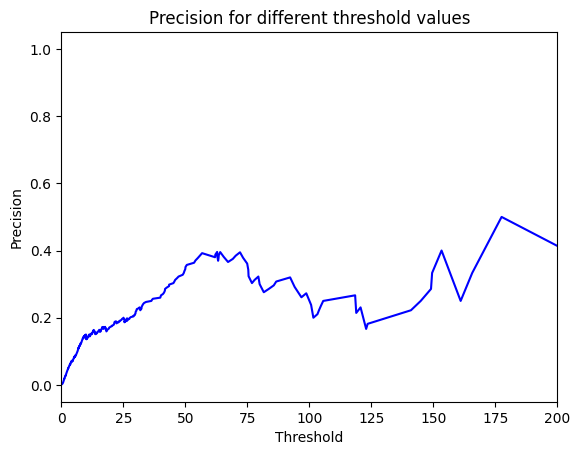

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.xlim([0,200])
plt.show()

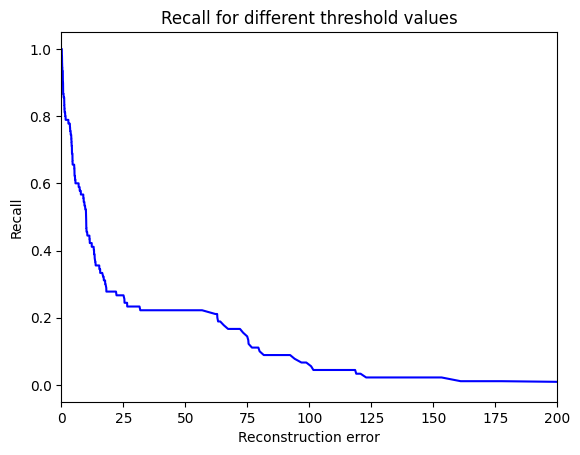

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.xlim([0,200])
plt.show()

In [ ]:
'''
from sklearn.metrics import f1_score

f1_scores = [f1_score(error_df.true_class, error_df.reconstruction_error > threshold) for threshold in th]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(th, f1_scores, label='F1-score Curve', color='red')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score Curve')
plt.legend()

plt.tight_layout()
plt.show()
'''

높은 정밀도(FP)는 거짓(정상 데이터)인데 참(사기 데이터)이라고 예측한 것들의 비율이 낮은 것과 관련 있고, 높은 재현율(FN)은 참(사기 데이터)인데 거짓(정상 데이터)이라고 예측한 것들의 비율이 낮은 것과 관련 있다.

두 값 모두 높다면 해당 분류기가 실제 참인 데이터들 중 대부분을 찾아낼(높은 재현율)뿐만 아니라, 정확한 결과(높은 정밀도)를 가진다는 것을 의미한다.

하지만 FN의 경우가 손실이 더 크기 때문에 FN을 감소시키는 전략을 취하는 것이 적합할 것이다. 따라서 재현율에 더 초점을 맞추어 평가한다.

In [ ]:
threshold = 10
# threshold = 10

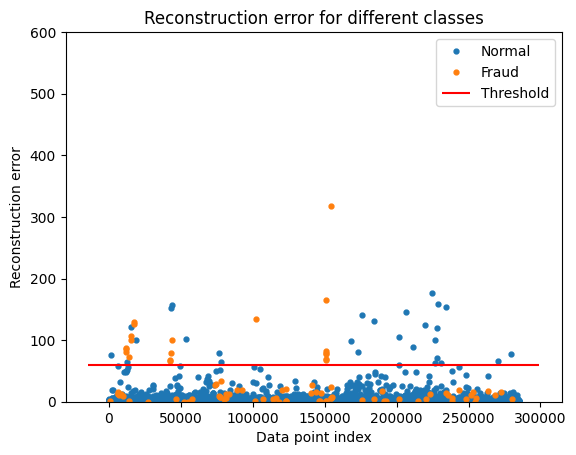

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim([0, 600])
plt.show();

Text(0.5, 0, 'range of reconstruction errors')

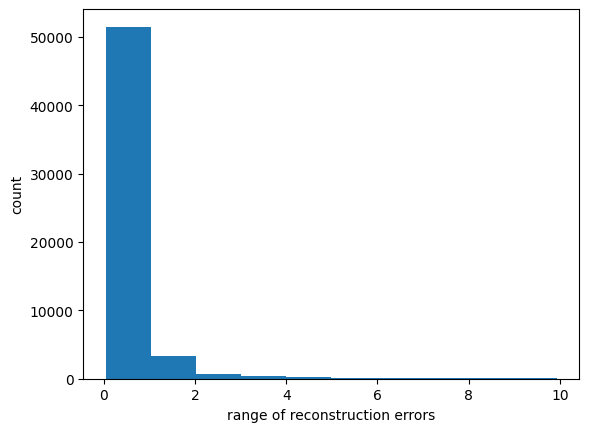

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.ylabel("count")
plt.xlabel("range of reconstruction errors")

Text(0.5, 0, 'range of reconstruction errors')

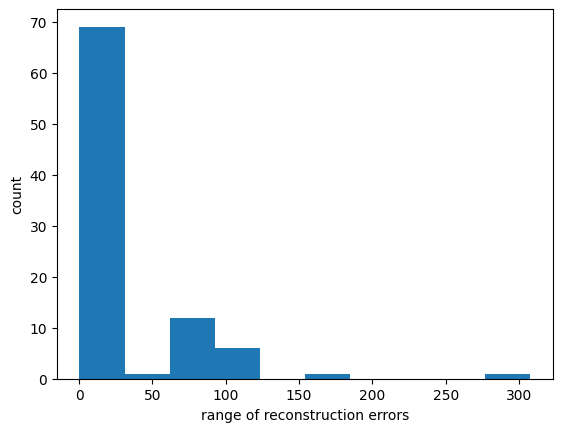

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.ylabel("count")
plt.xlabel("range of reconstruction errors")
    # [사기거래일수록 재구성오류(reconstruction_error)의 크기가 큰 경우가 다수 포진해 있음을 확인할 수 있다.]
    # [깨끗한 트랜잭션의 대부분은 2 미만의 재구성 손실을 갖는 반면 사기 트랜잭션의 경우 재구성 손실은 10까지 높을 수 있음을 알 수 있습니다.]
    # [이는 오토인코더가 사기 트랜잭션보다 깨끗한 트랜잭션을 더 정확하게 재구성할 수 있음을 의미합니다.]

##### 4) 평가

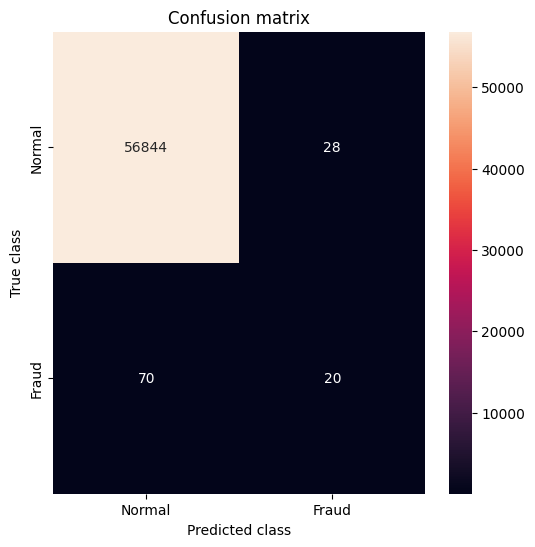

In [ ]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
TP = 56844
FP = 28
FN = 70
TN = 20

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Precision, Recall

(0.9995076663384442, 0.9987700741469586)



---



##### 그 밖의 Trial&Errors

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, X_test, threshold)
print_stats(preds, test_labels)

NameError: ignored

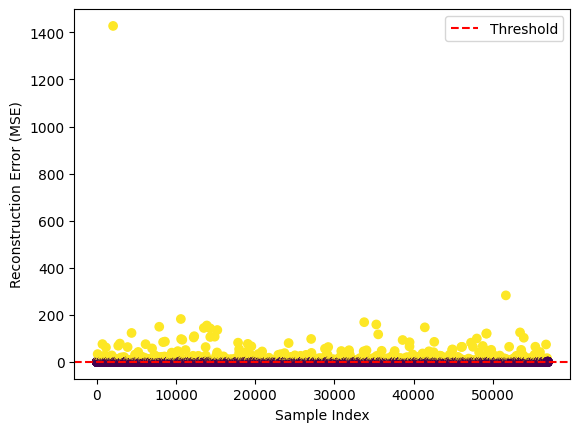

In [ ]:
# 예시 코드
threshold = np.percentile(mse, 95)  # 임계값 설정
predictions = (mse > threshold).astype(int)

plt.scatter(range(len(mse)), mse, c=predictions, cmap='viridis')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.show()


In [ ]:
threshold = 2.9

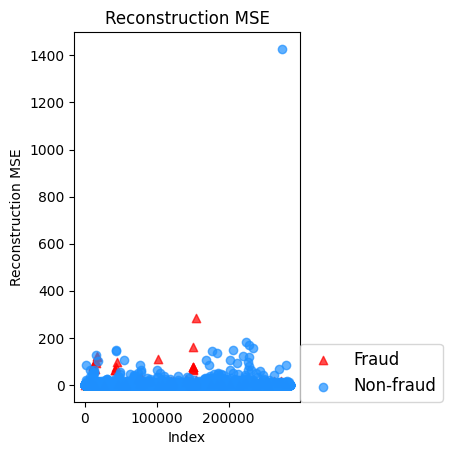

In [ ]:
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'red']
labels = ['Non-fraud', 'Fraud']

plt.subplot(122)
for flag in [1, 0]:
    temp = error_df[error_df['true_class'] == flag]
    plt.scatter(temp.index,
                temp['reconstruction_error'],
                alpha=0.7,
                marker=markers[flag],
                c=colors[flag],
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12)
plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE')
plt.xlabel('Index')
plt.show()

1781/1781 [==============================] - 6s 3ms/step


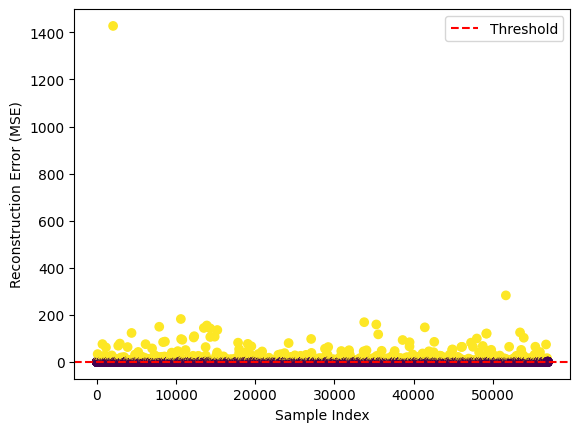

In [ ]:
# 테스트 데이터에 대한 예측과 재구성 오차 계산
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=1)

# 이상치 탐지를 위한 임계값 설정 (예: 95 백분위수)
threshold = np.percentile(mse, 95)

# 이상치 예측
predictions = (mse > threshold).astype(int)

# 이상치 시각화
plt.scatter(range(len(mse)), mse, c=predictions, cmap='viridis')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.show()


In [ ]:
def plot_precision_recall_curves(df):
    # Calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(labels, preds)

    # Plot recall precision tradeoff
    sns.set(style="white")
    plt.figure(figsize=(8,6))
    plt.step(recall, precision, color= 'purple', alpha=0.4, where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color=purple)
    plt.title('Recall vs Precision', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    experiment.log_figure(figure=plt)
    #plt.savefig('precision_recall_curve_x.png')
    print(plt.show())

    # Plot precision and recall for different thresholds
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precision[1:], label="Precision",color= 'orange', linewidth=2.5)
    plt.plot(thresholds, recall[1:], label="Recall",color= 'purple', alpha=0.9,linewidth=2.5)
    plt.title('Precision and recall for different threshold values', fontsize=16)
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend()
    experiment.log_figure(figure=plt)
    #plt.savefig('threshold_values_x.png')
    plt.show()

ValueError: ignored

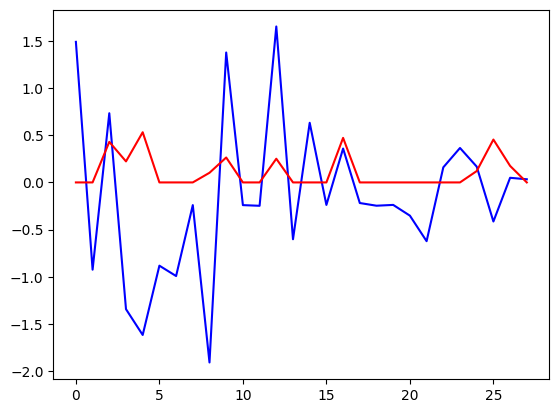

In [ ]:
encoded_data = autoencoder.encoder(X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()